## **DBSCAN Model**

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
## Function to tune the DBSCAN model by changing the epsilon and min_samples values
def tune_dbscan(data):

    results = []

    # define a range of eps and min_samples values to loop through
    eps_values = np.arange(.1, 10, .1)
    min_samples_values = np.arange(2, 10, 1)

    # loop through the combinations of eps and min_samples
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan.fit(data)
            labels = dbscan.labels_

            # count the number of clusters (excluding noise points labeled as -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            # count the number of noise points (labeled as -1)
            n_noise = list(labels).count(-1)

            # calculate the silhouette score
            if n_clusters > 1:  # silhouette score requires at least 2 clusters
                silhouette = silhouette_score(data, labels, metric='euclidean', sample_size=None)
            else:
                silhouette = None

            results.append([eps, min_samples, n_clusters, n_noise, silhouette])

    # put the results in a dataframe
    dbscan_results = pd.DataFrame(results, columns=["Eps", "Min Samples", "Number of Clusters",
                                                    "Number of Noise Points", "Silhouette Score"])
    dbscan_results = dbscan_results.sort_values('Silhouette Score',ascending=False)
    return dbscan_results

In [3]:
data = pd.read_csv('../Data/tripadvisor_reviews.csv')

In [4]:
X = data.drop('user_id', axis=1)

In [5]:
X.head()

,avg_museum_rating,avg_park_rating,avg_restaurant_rating,avg_nightlife_rating
0,1.93,2.8,3.29,1.62
1,2.02,3.2,3.66,1.64
2,2.22,1.8,1.54,1.53
3,1.45,2.8,1.29,1.57
4,1.51,2.2,2.18,1.57


In [6]:
## Scale the features
from sklearn.preprocessing import StandardScaler

sd = StandardScaler()
X_std = sd.fit_transform(X)

In [11]:
X_std = pd.DataFrame(X_std, columns=X.columns)

In [12]:
X_std.mean()

avg_museum_rating       -4.350262e-17
avg_park_rating         -4.422766e-16
avg_restaurant_rating    1.740105e-16
avg_nightlife_rating     9.063045e-17
dtype: float64

In [19]:
## tune the DBSCAN model to find the best hyperparameters
dbscan_result = tune_dbscan(X_std).reset_index()

In [20]:
dbscan_result.head()

,index,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
0,192,2.5,2,2,2,0.711727
1,184,2.4,2,2,2,0.711727
2,176,2.3,2,2,3,0.705965
3,168,2.2,2,2,4,0.696981
4,120,1.6,2,2,10,0.635939


In [21]:
## Fit the DBSCAN model using the best Silhouette Score
dbscan = DBSCAN(eps=dbscan_result['Eps'].iloc[0],
                min_samples=dbscan_result['Min Samples'].iloc[0]
               )
dbscan.fit(X_std)

DBSCAN(eps=np.float64(2.5000000000000004), min_samples=np.int64(2))

In [23]:
## Note the anomalies
np.count_nonzero(dbscan.labels_==-1)

2

In [25]:
np.sum(dbscan.labels_==-1)

np.int64(2)

In [24]:
from collections import Counter
Counter(dbscan.labels_)

Counter({np.int64(0): 976, np.int64(1): 2, np.int64(-1): 2})

In [26]:
## Add the anomalies in the original dataframe
data['anomaly_dbscan'] = dbscan.labels_

In [28]:
data[data['anomaly_dbscan']==-1]

,user_id,avg_museum_rating,avg_park_rating,avg_restaurant_rating,avg_nightlife_rating,anomaly_dbscan
601,User 602,2.15,1.80,1.26,4.10,-1
666,User 667,2.95,2.52,2.94,4.44,-1


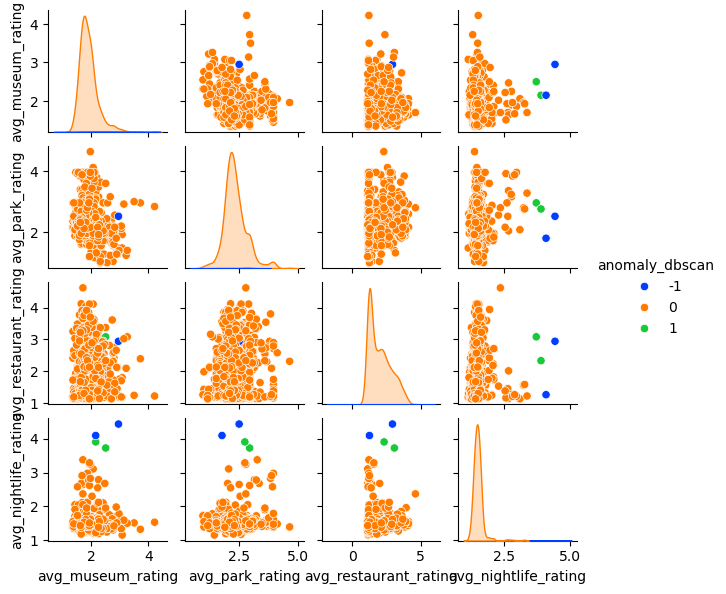

In [30]:
import seaborn as sns
sns.pairplot(
    data,
    hue='anomaly_dbscan',
    palette='bright',
    height=1.5
);